<a href="https://colab.research.google.com/github/tlm-design/idsn544/blob/main/Tara_SmallAssignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This model predicts whether an x-ray shows a fractured bone or not. It is trained with a dataset from kaggle. We first import the kaggle dataset into colab and unzip it. The dataset contains images. We then create our dataloader and pass the images to our learner for training. Finally, we can export our learner to be used in our production app.

Start by importing fastai.

In [ ]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
import fastai
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
Mounted at /content/gdrive


In [ ]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

We can import the widgets library for cleaning our data after training.

In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

Here, I've mounted the google drive so I can access the kaggle dataset after runtime.

In [ ]:
from google.colab import drive
drive. mount ('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

We can now download the dataset using this api command and then unzip it.

In [ ]:
!kaggle datasets download -d bmadushanirodrigo/fracture-multi-region-x-ray-data

Dataset URL: https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data
License(s): ODC Public Domain Dedication and Licence (PDDL)
 98% 473M/481M [00:07<00:00, 91.4MB/s]
100% 481M/481M [00:07<00:00, 65.7MB/s]


In [ ]:
!unzip -qq '/content/fracture-multi-region-x-ray-data.zip'

In [ ]:
path=Path('/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification')
fns = get_image_files(path)
fns

(#10581) [Path('/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/89-rotated3-rotated3-rotated3.jpg'),Path('/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/0001517989.png'),Path('/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/95-rotated3-rotated1-rotated1.jpg'),Path('/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/94f6a-pclavulsion1a.png'),Path('/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/72c9b4c7b122501e57f63da52f0e1e_gallery.jpeg'),Path('/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/pathological.jpg'),Path('/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured/88-rotated2-rotated2-rotated2.jpg'),Path('/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Bi

These weren't downloaded from duck duck go, so I wasn't sure if we would have to verify the images. I run verify to see what happens.

In [ ]:
failed = verify_images(fns)
failed

(#18) [Path('/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004148.jpg'),Path('/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004134.jpg'),Path('/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004143.jpg'),Path('/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004347.jpg'),Path('/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004308.jpg'),Path('/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured/IMG0004149.jpg'),Path('/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004148.jpg'),Path('/content/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured/IMG0004134.jpg'),Path('/content/

Looks like there are some failed images, lets remove them.

In [ ]:
failed.map(Path.unlink);

We can now create our dataloader from our data. Since we are using images, we create an ImageBlock.

In [ ]:
bones = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = bones.dataloaders(path)

Now let's take a look at a few.

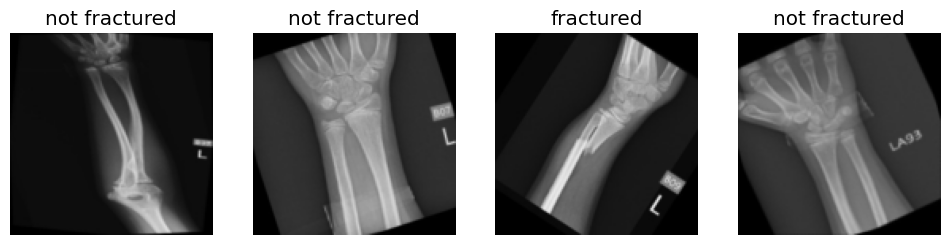

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
bones = bones.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bones.dataloaders(path)

We can pass our data to our learner for training. Let's use 4 epochs.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.587480,0.227849,0.084754,01:08


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.202192,0.044564,0.018939,01:10
1,0.082888,0.033820,0.011364,01:05
2,0.036730,0.025509,0.008523,01:07
3,0.023057,0.021475,0.007576,01:06


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Here we can use the confusion matrix to see our model's performance and then take a look at the top losses.

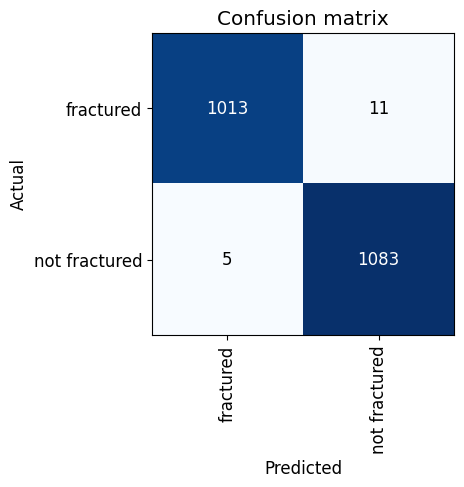

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

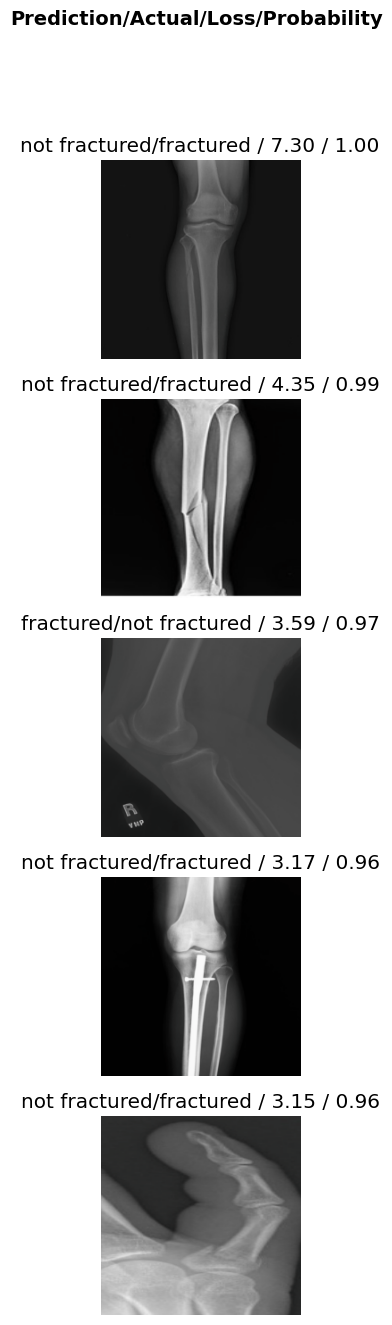

In [ ]:
#check top 5
interp.plot_top_losses(5, nrows=5)

Using the cleaner, we can then clean the data to improve performance. Since I am not experienced in reading x-rays, I skipped this in practice.

In [ ]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Finally, we can export our model to be used in production

In [ ]:
learn.export()